In [9]:
# imports
import numpy as np
import os
import sys
from pathlib import Path
from importlib import reload

from joblib import Parallel, delayed
import seaborn as sns
import pandas as pd


### timeseries generation

In [2]:
def generate_zipf(lenght = 100, param = 1.5, random_seed = 0):
    np.random.seed(random_seed)
    pages = np.random.zipf(a = param, size = lenght)
    return pages

def generate_zipf_trend(lenght = 100, period = 10, param = 1.5, random_seed = 0):
    shift = 0
    np.random.seed(random_seed)
    for i in range(1, lenght + 1):
        page = np.random.zipf(a = param) + shift
        yield page
        if i % period == 0:
            shift += 10

### policies
кэширующие алгоритмы. 

**cache_obs** -- LRU алгоритм со взглядом на будущее. при параметре P = 1 получаем простой LRU. Нужен для сравнения.

**cache_prob_mul** -- кэширующий алгоритм работающий с весом таблицы. Изменения веса:
$$
w_{t + 1} = w_t (1 - \gamma)^{1 - {\mathbb{\delta}} \{w \text{ is requested}\}}\beta^{{\mathbb{\delta}} \{w \text{ is requested}\}}
$$

условия на параметры:
$0< \gamma < 1 < \beta$. Второе условие чтобы веса не сошли в 0.


**cache_prob** -- кэширующий алгоритм работающий с весом таблицы. Изменения веса:
$$
w_{t + 1} = (1 - \gamma) w_t  + \beta {\mathbb{\delta}} \{w \text{ is requested}\}
$$

условия на параметры:
$0< \gamma < 1$, $ \gamma < \beta$. Второе условие чтобы веса не сошли в 0.





In [3]:
def cache_obs(requests, K, P, N):
    miss = 0
    cache = [None for i in range(K)]
    for pos in range(len(requests)):
        observations = requests[pos: min(pos + P, len(requests))]
        req = requests[pos]
        # print(cache, req)
        if req in cache:
            cache.remove(req)
            cache.append(req)
        else:
            if None in cache:
                del cache[0]
            else:
                C_obs = set(cache) - set(observations)
                if len(C_obs) != 0: # есть элемент для удаления
                    ind = 0
                    while not (cache[ind] in C_obs):
                        ind += 1
                    # нашли индекс для удаления
                    del cache[ind]
                else: # все элементы в кэше запрошены на будущее. удаляем то, которое запрошено на более позднее время
                    _key = None
                    mmin = -np.inf
                    for key in cache: 
                        try:
                            ind = observations.index(key)
                        except:
                            ind = np.inf  #not found
                        if ind > mmin:
                            mmin = ind
                            _key = key
                    
                    cache.remove(_key)
            cache.append(req)
            miss += 1
    return miss / len(requests)

In [4]:
from collections import defaultdict

from collections import defaultdict
def cache_prob_mul(requests, K, N, gamma = 0.001, beta = 1.2):
    eps = 0.1
    # gamma = 0.001
    # beta = 1.2
    miss = 0
    cache = [None for i in range(K)]
    weights = defaultdict(lambda : 0.5)
    times = defaultdict(lambda : 0.)   # time from last need
    for pos in range(len(requests)):
        req = requests[pos]
        # print(cache, req)
        if req not in times.keys():
            times[req] = pos
        weights[req] = max(eps, weights[req] * (1 - gamma) ** (pos - times[req]))
        weights[req]  = min(1. - eps,  weights[req]* beta)  # update weight of page
        times[req] = pos
        
        if req in cache:
            cache.remove(req)
            cache.append(req)
        else:
            if None in cache:
                del cache[0]
            else:
                while True:
                    item = cache[0]
                    weight = weights[item] 
                    p = weight
                    survive = np.random.choice([False, True], p = [1 - p, p])
                    if survive:
                        del cache[0]
                        cache.append(item)
                    else:
                        del cache[0]
                        break
            cache.append(req)
            miss += 1
        # renovate weight
        
    return miss / len(requests), weights

In [5]:

def cache_prob(requests, K, N, gamma = 0.01, beta = 0.1):
    eps = 0.1
    # gamma = 0.0001
    # beta = 0.13
    miss = 0
    cache = [None for i in range(K)]
    weights = defaultdict(lambda : 0.5)
    times = defaultdict(lambda : 0.)   # time from last need
    for pos in range(len(requests)):
        req = requests[pos]
        # print(cache, req)
        if req not in times.keys():
            times[req] = pos
        weights[req] = max(eps, weights[req] * (1 - gamma) ** (pos - times[req]))
        weights[req]  = min(1. - eps,  weights[req]  + beta)  # update weight of page
        times[req] = pos
        
        if req in cache:
            cache.remove(req)
            cache.append(req)
        else:
            if None in cache:
                del cache[0]
            else:
                while True:
                    item = cache[0]
                    weights[item] = max(eps, weights[item] * (1 - gamma) ** (pos - times[item]))
                    times[item] = pos
                    weight = weights[item] 
                    p = weight #(weight - np.min(list(weights.values()))) / (weight + weights[req] -  2 * np.min(list(weights.values())))
                   
                    survive = np.random.choice([False, True], p = [1 - p, p])
                    if survive:
                        del cache[0]
                        cache.append(item)
                    else:
                        del cache[0]
                        break
            cache.append(req)
            # weights[req] = 0.5
            miss += 1
        # renovate weight
        
    return miss / len(requests), weights

### experiments

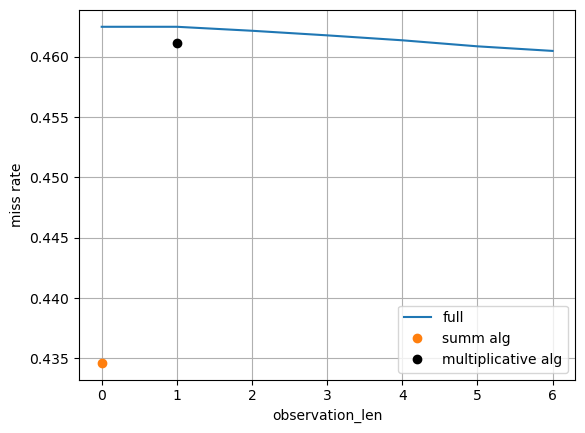

(17999, 0.9) (7820, 0.9) (4761, 0.9) 19333 0.5239722126107877
(17999, 0.9) (7820, 0.9) (4761, 0.9) 19333 0.5647921480816189


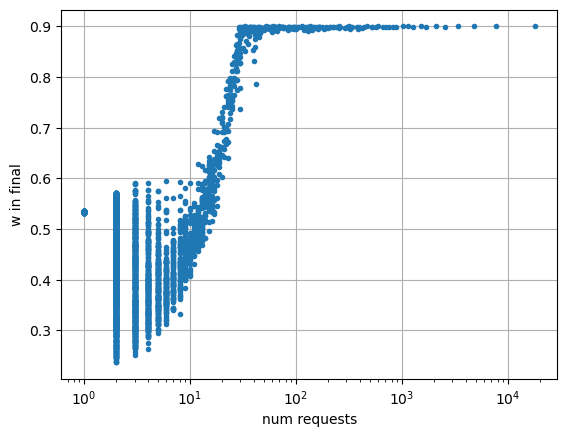

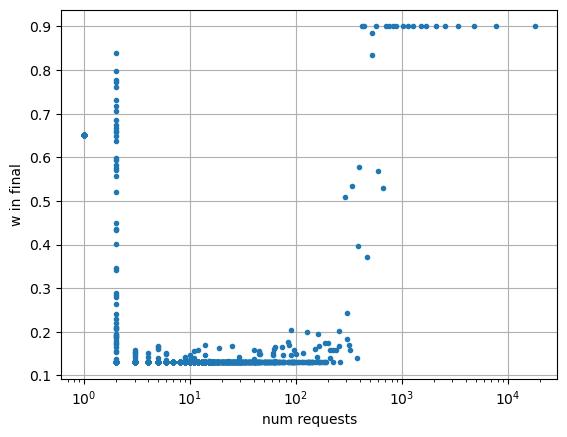

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import dataset_generator as generators
from collections import Counter

t = 100_000
N = 1000 # количество различных файлов. N не актуально если используется zipf генератор
K = 100

# dataset = generate(N, t, 0)
# requests = list(dataset)
seed = np.random.randint(1000)


# вызов разных генераторов
requests = list(generate_zipf(t, 1.2, seed))
# requests = list(generate_zipf_trend(t, t// 1000, 1.1, seed))
# requests = list(np.concatenate([list(range(N)) for i in range(10)]))
# requests = [np.random.randint(0, N) for i in range(t)]


p_list = range(0, 7, 1)
miss_rates = [cache_obs(requests, K, p, N) for p in p_list]
miss_prob, weights = cache_prob(requests, K,  N, 0.00001, 0.036)
miss_prob_mul, weights_mul = cache_prob_mul(requests, K,  N, 0.001, 1.3)
miss_prob = [miss_prob]
miss_prob_mul = [miss_prob_mul]

plt.plot(p_list, miss_rates, label = 'full')
plt.plot(0, miss_prob, 'o', label = "summ alg")
plt.plot(1, miss_prob_mul, 'o' ,color = 'black', label = "multiplicative alg")
plt.legend()
plt.grid()
plt.ylabel("miss rate")
plt.xlabel("observation_len")
plt.show()

counts = Counter(requests)
tmp = {key: (counts[key], weights[key]) for key in counts.keys()}
print(tmp[1], tmp[2], tmp[3], len(tmp), np.mean(list(weights.values())))
tmp = {key: (counts[key], weights_mul[key]) for key in counts.keys()}
print(tmp[1], tmp[2], tmp[3], len(tmp), np.mean(list(weights_mul.values())))

def plot_counts(w):
    plt.plot(counts.values(), w.values(), '.')
    plt.xscale('log')
    plt.grid()
    plt.xlabel('num requests')
    plt.ylabel('w in final')
    plt.show()
    
plot_counts(weights)
plot_counts(weights_mul)


### hit maps

код расчета hitmap.  Параметры даются в переменных gammas и betas.

библиотека joblib нужна для распараллеливания

In [10]:
t = 100_000
N = 1000
K = 100

def plot_hit_map(requests):
    del_cache = delayed(cache_prob)
    betas_len = 10
    gammas_len = 15
    gammas = np.logspace( np.log10(0.01), np.log10(0.00000001), gammas_len)
    betas = np.logspace(np.log10(0.1), np.log10(0.00001), betas_len)
    grid = np.meshgrid(gammas, betas)
    grid_misses = Parallel(n_jobs=8)( del_cache(requests, K, N, gammas[i], betas[j]) for i in range(gammas_len) for j in range(betas_len)  )
    grid_misses = np.array([grid_misses[i][0] for i in range(len(grid_misses))])
    grid_misses = grid_misses.reshape(gammas_len, betas_len).T

    dataframe = pd.DataFrame(data = grid_misses, index = [f"{num:.2e}" for num in betas], columns= [f"{num:.2e}" for num in gammas])
    sns.heatmap(dataframe * 100, annot = True)
    plt.xlabel("gamma")
    plt.ylabel('beta')
    
    plt.show()

def plot_hit_map_mul(requests):
    del_cache = delayed(cache_prob_mul)
    betas_len = 10
    gammas_len = 15
    gammas = np.logspace( np.log10(0.01), np.log10(0.00000001), gammas_len)
    betas = np.logspace(np.log10(1.001), np.log10(1.5), betas_len)
    grid = np.meshgrid(gammas, betas)
    grid_misses = Parallel(n_jobs=8)( del_cache(requests, K, N, gammas[i], betas[j]) for i in range(gammas_len) for j in range(betas_len)  )
    grid_misses = np.array([grid_misses[i][0] for i in range(len(grid_misses))])
    grid_misses = grid_misses.reshape(gammas_len, betas_len).T

    dataframe = pd.DataFrame(data = grid_misses, index = [f"{num:.2e}" for num in betas], columns= [f"{num:.2e}" for num in gammas])
    sns.heatmap(dataframe * 100, annot = True)
    plt.xlabel("gamma")
    plt.ylabel('beta')
    
    plt.show()

тестирование на параметрах для алгоритма с суммой

при вызове 

requests = list(generators.generate_zipf_trend(t, t// 1000, 1.1, seed))

создается последовательность запросов длиной t и длительностью профиля t// 1000. Рекомендуется посмотреть код в начале.

zipf missmap


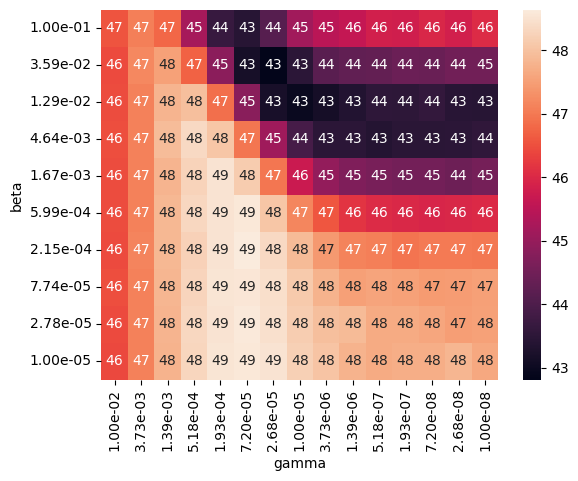

zipf trend missmap. len = 100


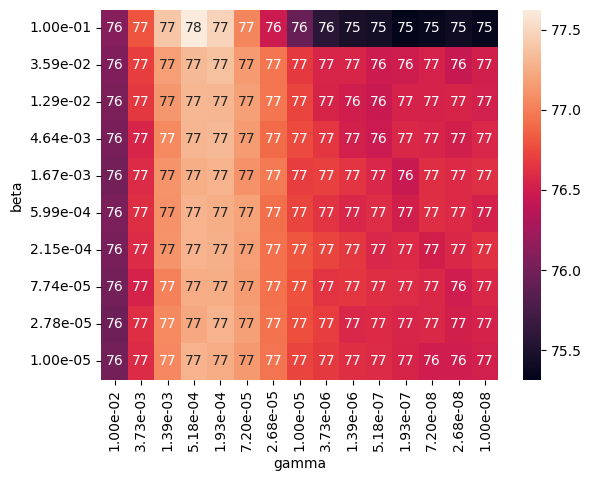

zipf trend missmap, len = 1000


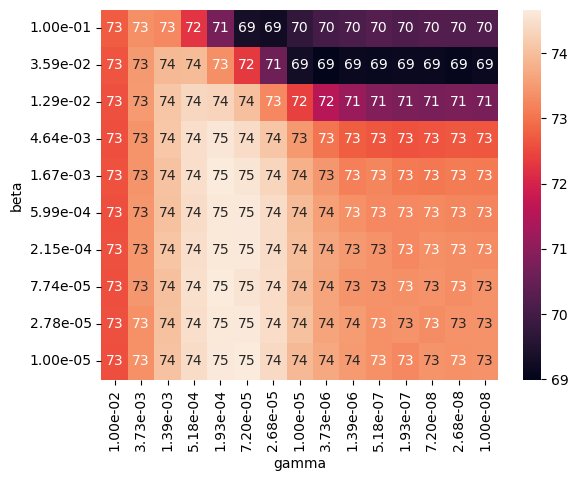

In [13]:
K = 100

# print("random missmap")
# requests = [np.random.randint(0, N) for i in range(t)]
# plot_hit_map(requests)

print('zipf missmap')
requests = list(generators.generate_zipf(t, 1.2, seed))
plot_hit_map(requests)

print('zipf trend missmap. len = 100')
requests = list(generators.generate_zipf_trend(t, t// 1000, 1.1, seed))
plot_hit_map(requests)

print('zipf trend missmap, len = 1000')
requests = list(generators.generate_zipf_trend(t, t// 100, 1.1, seed))
plot_hit_map(requests)

можно видеть, что в эксперименте с трендами при длине тренда $l = 1000$ лучшее значение $\beta$ меньше чем лучшее значение для длины тренда $l = 100$. То есть для более длительных изменений предпочтительно более медленное изменение

тестирование на параметрах для алгоритма с произведением

zipf missmap


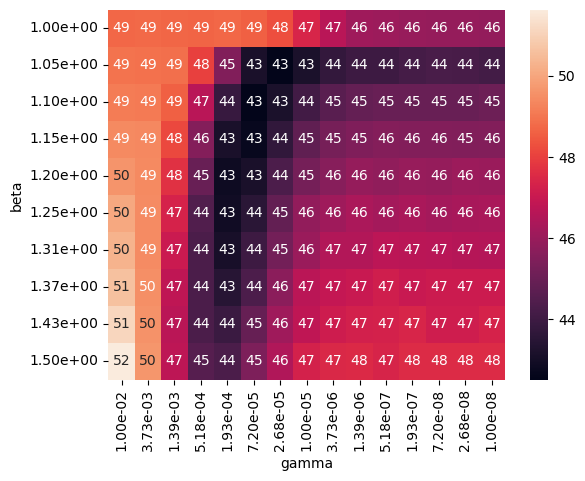

zipf trend missmap. len = 100


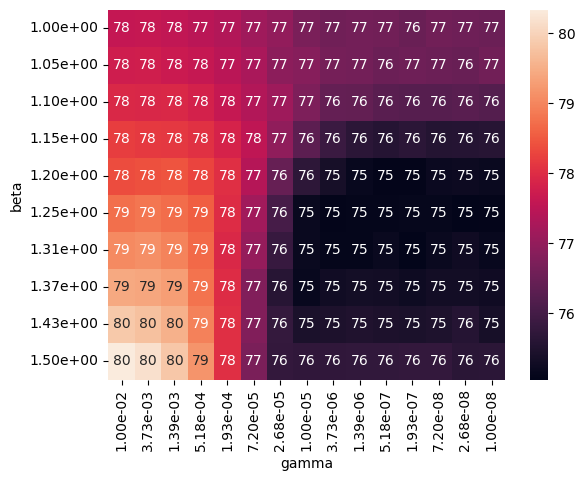

zipf trend missmap, len = 1000


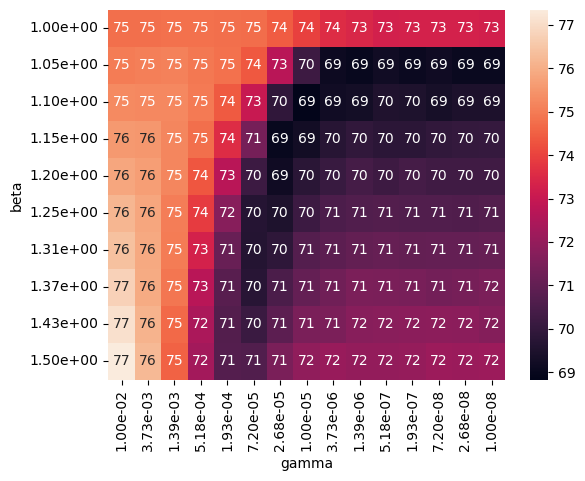

In [14]:
K = 100

# print("random missmap")
# requests = [np.random.randint(0, N) for i in range(t)]
# plot_hit_map_mul(requests)

print('zipf missmap')
requests = list(generators.generate_zipf(t, 1.2, seed))
plot_hit_map_mul(requests)

print('zipf trend missmap. len = 100')
requests = list(generators.generate_zipf_trend(t, t// 1000, 1.1, seed))
plot_hit_map_mul(requests)

print('zipf trend missmap, len = 1000')
requests = list(generators.generate_zipf_trend(t, t// 100, 1.1, seed))
plot_hit_map_mul(requests)

тут аналогичная ситуация. Для $l = 1000$ предпочтиельно значение $\beta$, которое дает более медленное изменение весов.